# Projeto 1

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

# seed para reproduzir experiências
g = torch.Generator().manual_seed(6)

PATH = os.getcwd()
print(PATH)

# read words to a list
words2014 = open(PATH + '/nomes/nomes-registados-2014.csv', 'r').read().splitlines()
words2015 = open(PATH + '/nomes/nomes-registados-2015.csv', 'r').read().splitlines()
words2016 = open(PATH + '/nomes/nomes-registados-2016.csv', 'r').read().splitlines()
words_test = open(PATH + '/nomes/nomes-registados-2017.csv', 'r').read().splitlines()
words_test = [i.split(',')[1].strip(". -'\"").lower() for i in words_test[1:]]
words = []
words.extend([i.split(',')[0].strip(". -'").lower() for i in words2014[1:]])
words.extend([i.split(',')[0].strip(". -'").lower() for i in words2015])
words.extend([i.split(',')[0].strip(". -'").lower() for i in words2016[1:]])
words

/Users/sofiafernandes/Documents/Repos/MEIM-ano1-sem2/avii-meim/projeto1


['maria',
 'matilde',
 'leonor',
 'beatriz',
 'mariana',
 'carolina',
 'ana',
 'inês',
 'sofia',
 'margarida',
 'lara',
 'joana',
 'laura',
 'francisca',
 'diana',
 'mafalda',
 'madalena',
 'clara',
 'luana',
 'sara',
 'bianca',
 'alice',
 'rita',
 'íris',
 'constança',
 'letícia',
 'eva',
 'gabriela',
 'camila',
 'yara',
 'benedita',
 'mara',
 'catarina',
 'ariana',
 'ema',
 'vitória',
 'marta',
 'carlota',
 'iara',
 'yasmin',
 'nicole',
 'luísa',
 'daniela',
 'núria',
 'bruna',
 'victória',
 'alícia',
 'rafaela',
 'helena',
 'miriam',
 'lia',
 'jéssica',
 'filipa',
 'júlia',
 'érica',
 'bárbara',
 'teresa',
 'isabel',
 'raquel',
 'kyara',
 'melissa',
 'valentina',
 'carminho',
 'juliana',
 'adriana',
 'noa',
 'luna',
 'alexandra',
 'débora',
 'violeta',
 'pilar',
 'mia',
 'mélanie',
 'soraia',
 'tatiana',
 'irina',
 'caetana',
 'kelly',
 'eduarda',
 'paloma',
 'maiara',
 'andreia',
 'nádia',
 'fabiana',
 'luciana',
 'renata',
 'amélia',
 'isabela',
 'naiara',
 'áurea',
 'lorena',
 'i

In [54]:
for i in words:
    if "'" in i:
        print(i)

n'deye
n'deye marie
bulerim n'dja
leonardo d'assis
karing'ö
n'nasta
m'mahawa
m'hammed
m'ma


## Conjuntos de treino, validação e teste

In [55]:
random.seed(6)
random.shuffle(words)
n1 = int(0.9*len(words))
words_train = words[:n1]
words_dev = words[n1:]
words_test = words_test

In [56]:
#### MAPEAMENTOS CARACTER-INDICE ####
# ordenar todos os caractéres existentes
chars = sorted(list(set(''.join(words_train))))
# adicionar o caracter inicial/final à lista de caracteres
chars = ['.'] + chars
# mapear caracter --> indice
stoi = {s:i for i,s in enumerate(chars)}
# mapear indice --> caracter
itos = {i:s for i,s in enumerate(chars)}

stoi, itos

({'.': 0,
  ' ': 1,
  "'": 2,
  '-': 3,
  'a': 4,
  'b': 5,
  'c': 6,
  'd': 7,
  'e': 8,
  'f': 9,
  'g': 10,
  'h': 11,
  'i': 12,
  'j': 13,
  'k': 14,
  'l': 15,
  'm': 16,
  'n': 17,
  'o': 18,
  'p': 19,
  'q': 20,
  'r': 21,
  's': 22,
  't': 23,
  'u': 24,
  'v': 25,
  'w': 26,
  'x': 27,
  'y': 28,
  'z': 29,
  'à': 30,
  'á': 31,
  'â': 32,
  'ã': 33,
  'ç': 34,
  'è': 35,
  'é': 36,
  'ê': 37,
  'ë': 38,
  'ì': 39,
  'í': 40,
  'ï': 41,
  'ñ': 42,
  'ó': 43,
  'ô': 44,
  'ö': 45,
  'ú': 46,
  'ü': 47,
  '̀': 48,
  '́': 49,
  '̂': 50,
  '̃': 51,
  '̈': 52,
  '̧': 53},
 {0: '.',
  1: ' ',
  2: "'",
  3: '-',
  4: 'a',
  5: 'b',
  6: 'c',
  7: 'd',
  8: 'e',
  9: 'f',
  10: 'g',
  11: 'h',
  12: 'i',
  13: 'j',
  14: 'k',
  15: 'l',
  16: 'm',
  17: 'n',
  18: 'o',
  19: 'p',
  20: 'q',
  21: 'r',
  22: 's',
  23: 't',
  24: 'u',
  25: 'v',
  26: 'w',
  27: 'x',
  28: 'y',
  29: 'z',
  30: 'à',
  31: 'á',
  32: 'â',
  33: 'ã',
  34: 'ç',
  35: 'è',
  36: 'é',
  37: 'ê',
  38: '

In [57]:
def build_dataset(words, block_size):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size  #[0, 0]
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


Xtr, Ytr = build_dataset(words_train, 1)
Xdev, Ydev = build_dataset(words_dev, 1)
Xte, Yte = build_dataset(words_test, 1)

torch.Size([224893, 1]) torch.Size([224893])
torch.Size([24971, 1]) torch.Size([24971])
torch.Size([32416, 1]) torch.Size([32416])


## 1.1. Modelo baseados em bigramas 
Com os parâmetros estimados através da realização de contagens no conjunto de treino:

In [58]:
#### DICIONÁRIO COM CONTAGENS DOS BIGRAMAS ####
bigram_counts = {}
# para cada nome
for w in words_train:
  # adicionar tokens iniciais e finais no inicio e no fim
  # w = ['<s>'] + list(w) + ['<e>']
  # para simplificar e diminuir o nº de bigramas usamos pontos (.) como token inicial e final
  w = ['.'] + list(w) + ['.']
  # para cada caracter um a seguir ao outro
  for ch1, ch2 in zip(w, w[1: ]):
    bigram = (ch1, ch2)
    # contabilizar o bigrama ou criar nova entrada caso não exista
    bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1


sorted(bigram_counts.items(), key= lambda kv: -kv[1])

[(('a', '.'), 6804),
 (('a', 'n'), 6432),
 (('i', 'a'), 4589),
 (('a', 'r'), 4426),
 (('e', 'l'), 4085),
 (('r', 'i'), 4030),
 (('a', ' '), 3999),
 (('n', 'a'), 3499),
 (('m', 'a'), 3439),
 (('r', 'a'), 2954),
 (('o', '.'), 2798),
 (('.', 'a'), 2495),
 (('l', 'i'), 2396),
 (('i', 'n'), 2266),
 (('.', 'm'), 2226),
 (('e', '.'), 2196),
 (('s', 'a'), 2142),
 (('o', ' '), 2096),
 (('a', 'l'), 2077),
 (('i', 's'), 2030),
 (('l', 'a'), 1956),
 (('l', 'e'), 1928),
 (('n', 'i'), 1887),
 (('e', 'n'), 1721),
 (('l', '.'), 1706),
 (('i', 'l'), 1664),
 (('n', '.'), 1660),
 (('.', 'l'), 1650),
 (('o', 'n'), 1484),
 ((' ', 'm'), 1460),
 (('d', 'a'), 1434),
 (('m', 'i'), 1421),
 (('n', 'd'), 1408),
 (('c', 'a'), 1383),
 (('.', 's'), 1359),
 (('d', 'r'), 1350),
 (('t', 'i'), 1343),
 (('.', 'd'), 1338),
 (('e', 'r'), 1323),
 (('i', 'e'), 1306),
 ((' ', 'a'), 1255),
 (('i', 'o'), 1228),
 (('a', 't'), 1226),
 (('.', 'j'), 1181),
 (('.', 'e'), 1179),
 (('v', 'i'), 1178),
 (('s', '.'), 1168),
 (('i', 'c'),

In [59]:
#### MATRIZ COM CONTAGENS DOS BIGRAMAS
# nº de caracteres mapeados
n_chars = len(stoi)
# criar matriz quadrada com dimensão do número de caracteres possíveis (+ 1)
N = torch.zeros((n_chars, n_chars), dtype=torch.int32)
# para cada palavra
for w in words_train:
    # fazer o mesmo só que com "."
    w = ['.'] + list(w) + ['.']
    # para cada caracter
    for ch1, ch2 in zip(w, w[1: ]):
        # linha do ch1
        ix1=stoi[ch1]
        # coluna do ch2
        ix2=stoi[ch2]
        # adiciona 1 à contagem
        N[ix1, ix2] += 1

N

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [2, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [60]:
# frequencias totais de cada caracter
N.sum(axis = 1, keepdim=True)#.shape

tensor([[21222],
        [10679],
        [    7],
        [   49],
        [34489],
        [ 2430],
        [ 4851],
        [ 6928],
        [15832],
        [ 2355],
        [ 3075],
        [ 3068],
        [20161],
        [ 2277],
        [ 1693],
        [13093],
        [ 7234],
        [15035],
        [11431],
        [ 1426],
        [  453],
        [14067],
        [ 9281],
        [ 5688],
        [ 5252],
        [ 2492],
        [  423],
        [  711],
        [ 3091],
        [ 1107],
        [    1],
        [  674],
        [  133],
        [  428],
        [  306],
        [    3],
        [ 1097],
        [  135],
        [   10],
        [    1],
        [  898],
        [   15],
        [    1],
        [  496],
        [    9],
        [    3],
        [  315],
        [    3],
        [    3],
        [  386],
        [   32],
        [   23],
        [   11],
        [   10]])

In [61]:
# cálculo da probabilidade de cada bigrama (n_chars*n_chars)
p = N / N.sum(axis=1, keepdim = True)
# verificar que as probabilidades somam para 1
p.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

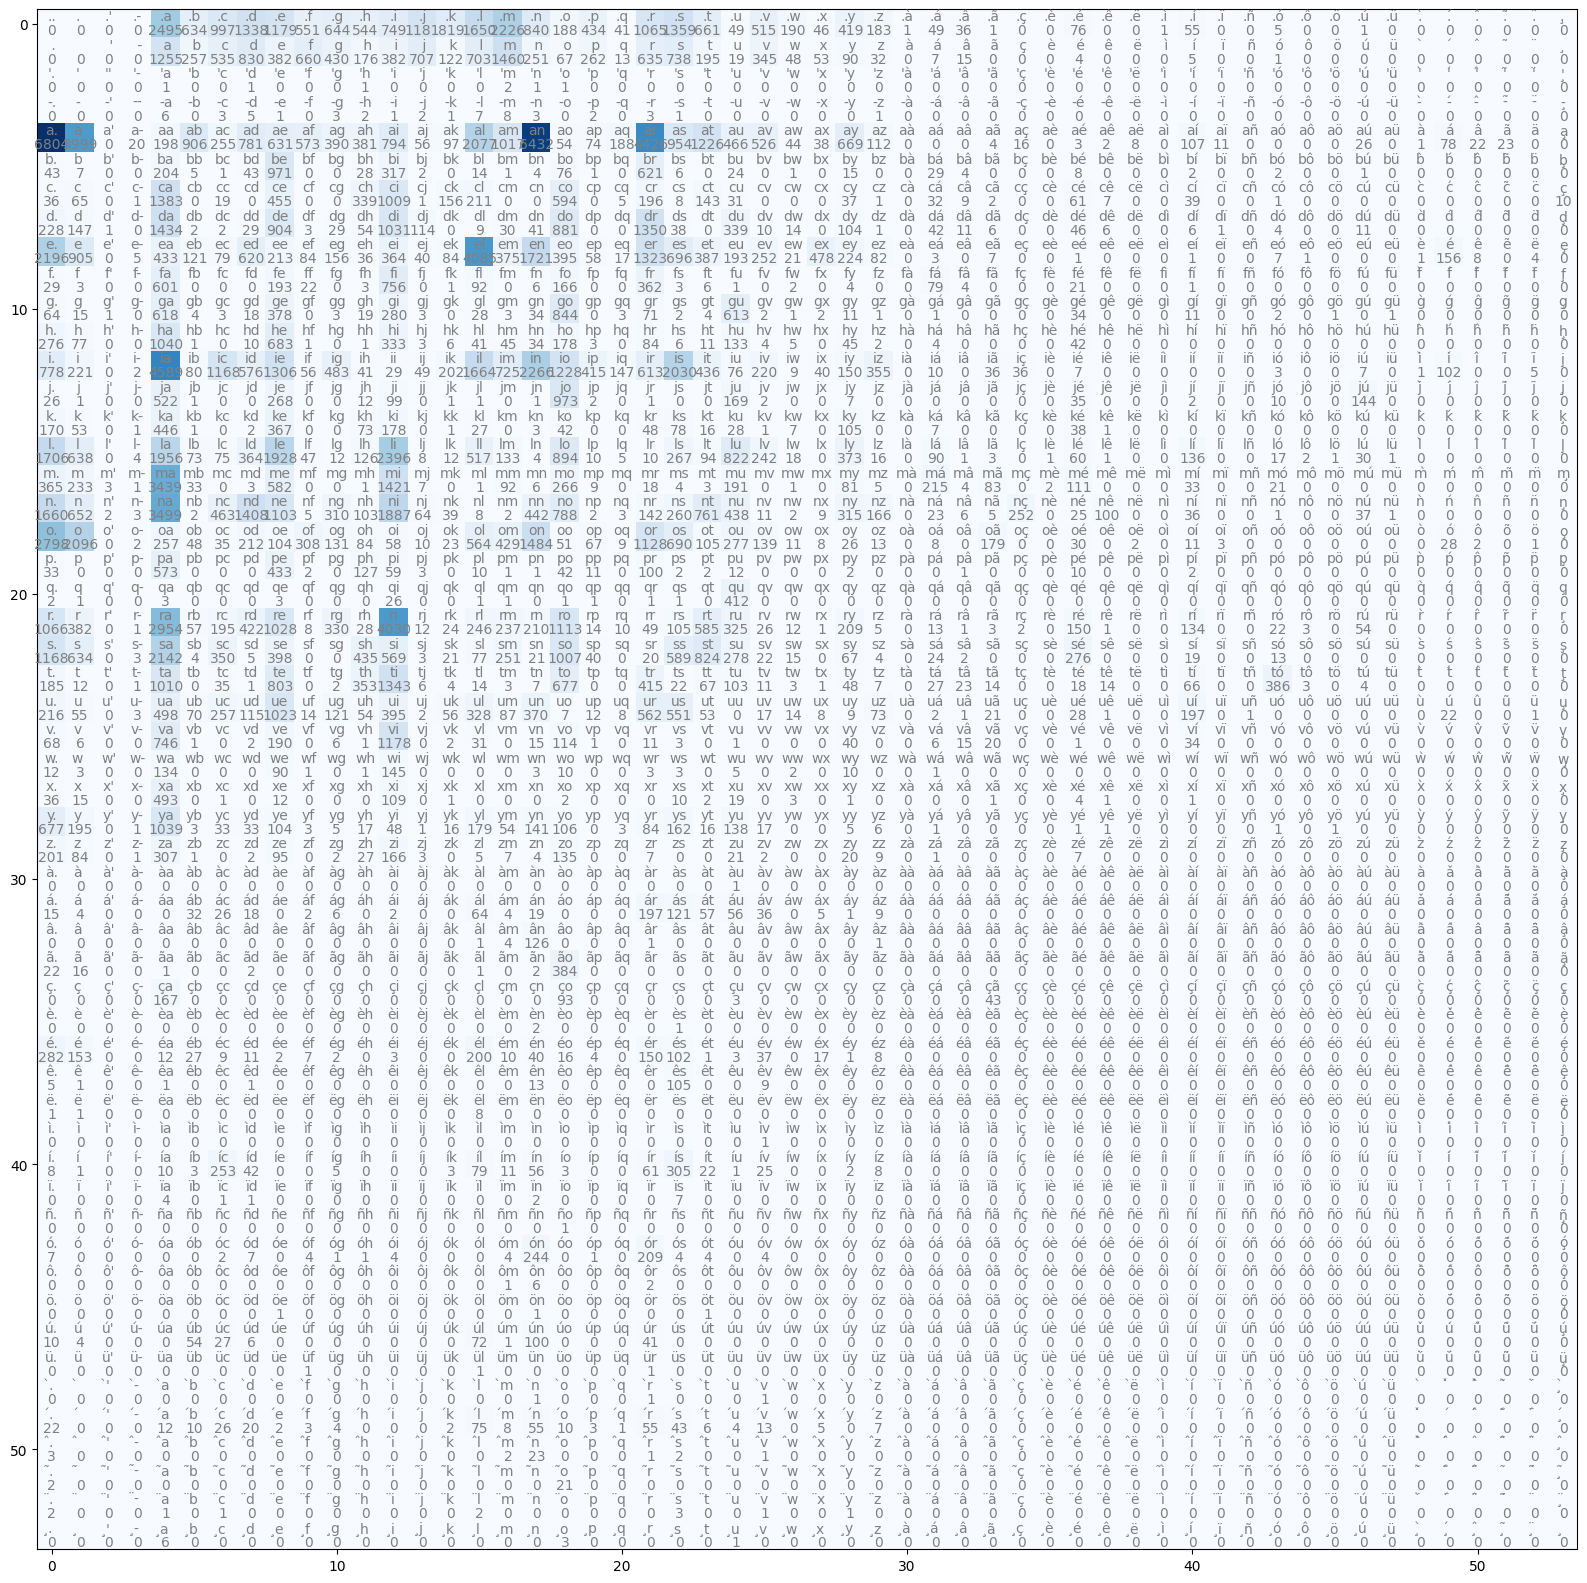

In [62]:
plt.figure(figsize=(20, 20))
plt.imshow(N, cmap='Blues')
for i in range(n_chars):
  for j in range(n_chars):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color= "gray")
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color= "gray")


In [63]:
### EXPERIMENTAR MODELO ####
n_tries = 5
for i in range(n_tries):
    out = [] # sequência output
    ix = stoi['.'] # ou 0, 1º caracter

    while True:
        # linha de probabilidades do caracter anterior
        pp = p[ix]
        # caracter seguinte, com base nas probabilidades obtidas das contagens
        ix = torch.multinomial(pp, num_samples=1, replacement=True, generator=g).item() # tensor, item() transforma tensor num numero
        out.append(itos[ix])
        # se o caracter previsto for o "." acabar previsioes pois é caracter final
        if ix == 0:
            break
    # juntar todos os tokens para apresentar como string
    print("".join(out))

lusalianute.
vinça l.
lora riarby.
kspandiarto mbesto.
ga.


In [64]:
#### AVALIAR MODELO NO CONJUNTO DE TESTE ####
y_pred = []
for ix in Xte:
  # linha de probabilidades do caracter anterior
  pp = p[ix]
  # caracter seguinte, com base nas probabilidades obtidas das contagens
  out = torch.multinomial(pp, num_samples=1, replacement=True, generator=g).item() # tensor, item() transforma tensor num numero
  y_pred.append(out)


print(classification_report(Yte, y_pred))
print(confusion_matrix(Yte, y_pred))
accuracy_score(Yte, y_pred)

              precision    recall  f1-score   support

           0       0.21      0.14      0.17      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.23      0.24      0.24      5053
           5       0.01      0.01      0.01       333
           6       0.03      0.04      0.03       558
           7       0.05      0.06      0.06       886
           8       0.12      0.12      0.12      2378
           9       0.01      0.02      0.02       207
          10       0.03      0.04      0.03       280
          11       0.07      0.04      0.05       809
          12       0.17      0.17      0.17      2823
          13       0.04      0.03      0.04       352
          14       0.04      0.03      0.03       443
          15       0.12      0.12      0.12      1963
          16       0.05      0.05      0.05      1044
          17       0.15      0.14      0.15      2457
          18       0.09    

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

0.12034180651530109

## 1.2. Modelo baseado em bigramas 
Com os parâmetros estimados através da otimização do critério de ML (Maximum Likelihood) dos dados de treino, usando o algoritmo de descida de gradiente

In [65]:
#create training set
xs, ys = [], []
for w in words_train:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1=stoi[ch1]
    ix2=stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

# filter train features and labels
xs = torch.tensor(xs)
ys = torch.tensor(ys)

#create test set
xt, yt = [], []
for w in words_test:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1=stoi[ch1]
    ix2=stoi[ch2]
    xt.append(ix1)
    yt.append(ix2)

# filter test features and labels
xt = torch.tensor(xt)
yt = torch.tensor(yt)

In [66]:
# inicializar com número aleatórios uma matriz 27x27 com gradientes calculados
W = torch.randn((n_chars,n_chars), generator=g, requires_grad=True)

for k in range(100):
  # codificar caracteres com one-hot encoding
  xenc = F.one_hot(xs, num_classes=n_chars).float()

  # produto interno do input codificado com a matriz de pesos, produz os logits
  # que representam as previsões do modelo para cada cclasse
  logits = xenc @ W

  # exponenciar logits para obter o tensor de contagens.
  counts = logits.exp()

  # normalizar as contagens para obter uma distribuição de probabilidade das classes 
  probs = counts / counts.sum(1, keepdim=True)

  # calcular a negative log likelihood (loss para este treino)
  loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() 

  # reiniciar gradientes
  W.grad = None

  # calcula os gradientes da loss com respeito aos parâmetros do modelo, usando back propagation
  loss.backward()

  # atualizar a matriz dos pesos W com os gradientes calculados, a regra usada é a descida de gradiente,
  # com uma taxa de aprendizagem fixa de 10. 
  W.data += -10*W.grad
print(loss)

tensor(2.8300, grad_fn=<NegBackward0>)


In [67]:
# experimentar modelo
for i in range(5):
  out = []
  ix = stoi['.']
  ix = 0
  while True:
    logits= W[ix]
    counts = logits.exp()
    probs = counts /counts.sum()
    ix= torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out)) 



mxñüisöoneinór.
mié́öyandrè'vëóüójo ïölhp̧fïdndilanipëf̀bxée.
-ë.
nre.
s'cúã.


In [68]:
#### AVALIAR NO CONJUNTO DE TESTE ###
y_pred = []
for ix in xt:
  logits= W[ix]
  counts = logits.exp()
  probs = counts /counts.sum()
  out = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
  y_pred.append(out)


print(classification_report(yt, y_pred))
print(confusion_matrix(yt, y_pred))
accuracy_score(yt, y_pred)

              precision    recall  f1-score   support

           0       0.20      0.12      0.15      4573
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.23      0.19      0.21      5053
           5       0.01      0.01      0.01       333
           6       0.03      0.03      0.03       558
           7       0.04      0.04      0.04       886
           8       0.10      0.07      0.08      2378
           9       0.00      0.00      0.00       207
          10       0.01      0.01      0.01       280
          11       0.04      0.02      0.02       809
          12       0.16      0.13      0.15      2823
          13       0.03      0.04      0.04       352
          14       0.03      0.02      0.02       443
          15       0.13      0.10      0.11      1963
          16       0.06      0.05      0.06      1044
          17       0.14    

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

0.09328726554787758

# 2. Modelo MLP (multilayer perceptron) com camada de "Embedding"


In [77]:
from tqdm import tqdm

def embedding_model_train(Xtr, Ytr, Xdev, Ydev, context, lr, dim, int_neurons, epochs):

    g = torch.Generator().manual_seed(6) # for reproducibility
    C = torch.randn((n_chars, dim), generator=g)
    W1 = torch.randn((dim*context, int_neurons), generator=g)
    b1 = torch.randn(int_neurons, generator=g)
    W2 = torch.randn((int_neurons, n_chars), generator=g)
    b2 = torch.randn(n_chars, generator=g)
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    lossi_tr, lossi_dev = [], []
    for i in tqdm(range(epochs)):
        # minibatches
        # ix = torch.randint(Xtr.shape[0], (32,))

        # forward pass
        emb = C[Xtr] # todos os embeddings do treino
        #print(C.shape)
        #print(emb.shape)
        h = torch.tanh(emb.view(-1, context*dim) @ W1 + b1) # vetor-contexto * W1-pesos da hidden + b1-bias da hidden
        logits = h @ W2 + b2 # multiplicar o resultado da hidden layer pelos pesos e bias da última layer
        loss = F.cross_entropy(logits, Ytr)
        lossi_tr.append(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        for p in parameters:
            p.data += -lr * p.grad

        # Evaluate in the validation set (is the model overfitting?)
        emb = C[Xdev]
        h = torch.tanh(emb.view(-1, context*dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ydev) # softmax + loss
        #print(i, loss.item())
        lossi_dev.append(loss.item())
    
    print("Dev loss:", loss)

    # Ver as posições finais dos embeddings
    tsne = TSNE(2, verbose=1, perplexity=6)
    tsne_proj = tsne.fit_transform(C.detach())
    plt.figure(figsize=(10,10))
    plt.scatter(tsne_proj[:,0].data, tsne_proj[:,1].data, s=200)
    for i in range(tsne_proj.shape[0]):
        plt.text(tsne_proj[i,0], tsne_proj[i,1], itos[i], ha="center", va="center", color='white')
    plt.grid('minor')
    
    plt.figure(figsize=(10,10))
    plt.plot(lossi_tr)
    plt.plot(lossi_dev)
    
    return parameters


def embedding_model(words_train, words_dev, words_test, context, lr, dim, int_neurons, epochs):


    Xtr, Ytr = build_dataset(words_train, context)
    Xdev, Ydev = build_dataset(words_dev, context)
    Xte, Yte = build_dataset(words_test, context)

    parameters = embedding_model_train(Xtr, Ytr, Xdev, Ydev, context, lr, dim, int_neurons, epochs)
    return parameters


def embedding_model_predict(Xte, parameters):

    # desempacotar parametros
    C, W1, b1, W2, b2 = parameters

    # não precisamos dos gradientes porque estamos em modo de inferência
    with torch.no_grad(): 
        # deduzir dimensão dos embedding e tamanho do contexto
        dim = C.shape[1]
        context = int(W1.shape[0]/dim)

        # previsões no conjunto de teste
        emb = C[Xte]
        h = torch.tanh(emb.view(-1, context*dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(probs, dim=1)

        print("Test Loss:", F.cross_entropy(logits, Yte)) 
    
    return preds

def experiment(context, dim, int_neurons, lr, epochs):
    # conjuntos de treino, validação e teste preparados para o tamanho do contexto
    Xtr, Ytr = build_dataset(words_train, context)
    Xdev, Ydev = build_dataset(words_dev, context)
    Xte, Yte = build_dataset(words_test, context)

    # treinar o modelo
    model = embedding_model_train(Xtr, Ytr, Xdev, Ydev, context, lr, dim, int_neurons, epochs)

    # previsões no conjunto de teste
    y_pred = embedding_model_predict(Xte, model)

    # avaliação no conjunto de teste
    print("Test Accuracy:", accuracy_score(Yte, y_pred))
    print(classification_report(Yte, y_pred))
    print(confusion_matrix(Yte, y_pred))
    
        



## Experiência 1:
- tamanho do contexto: 2
- dimensão dos embeddings: 2
- nº de neurónios intermédios: 100

torch.Size([224893, 2]) torch.Size([224893])
torch.Size([24971, 2]) torch.Size([24971])
torch.Size([32416, 2]) torch.Size([32416])


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Dev loss: tensor(2.8461, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.005s...
[t-SNE] Computed neighbors for 54 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.230462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.846790
[t-SNE] KL divergence after 1000 iterations: 0.200606
Test Loss: tensor(2.9435)
Test Accuracy: 0.1749444718657453
              precision    recall  f1-score   support

           0       0.24      0.60      0.35      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.00      0.00      0.00       886
           8       0.13      0.33      0.18      2378
           9       0.00      0.00      0

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

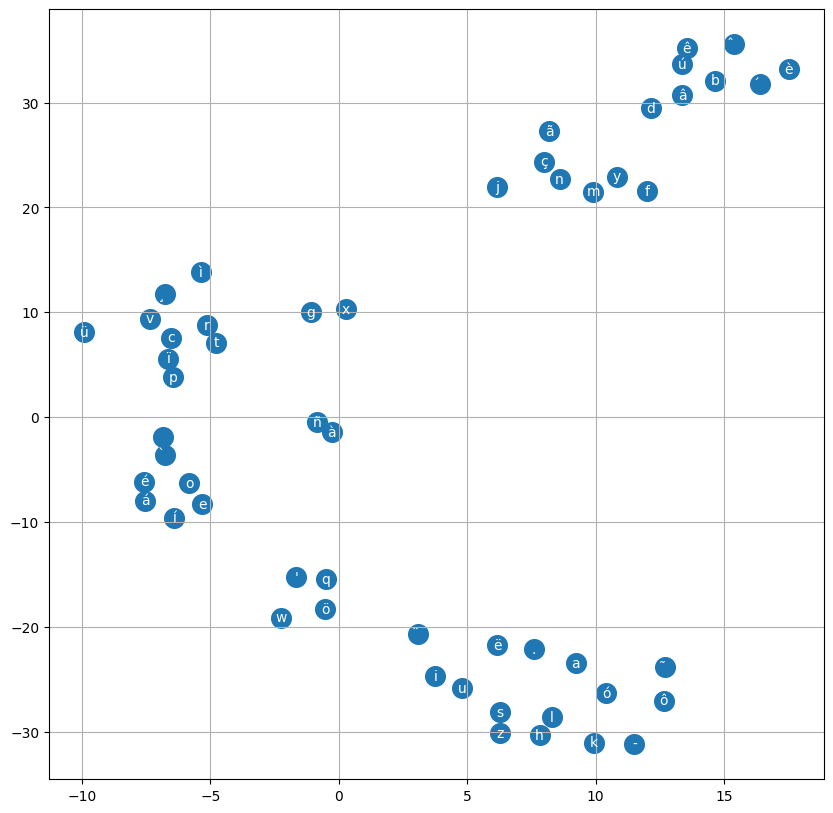

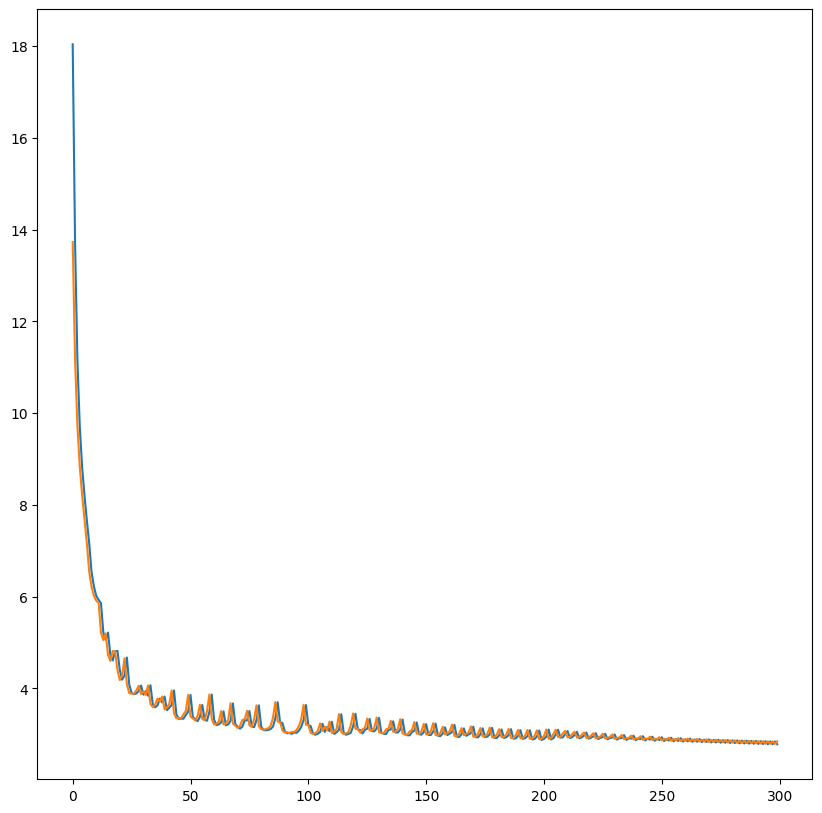

In [78]:
# hiper-parâmetros
context = 2
dim = 2
int_neurons = 100
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)


## Experiência 2.0:
- tamanho do contexto: 3
- dimensão dos embeddings: 2
- nº de neurónios intermédios: 100

torch.Size([224893, 3]) torch.Size([224893])
torch.Size([24971, 3]) torch.Size([24971])
torch.Size([32416, 3]) torch.Size([32416])


100%|██████████| 300/300 [02:17<00:00,  2.18it/s]


Dev loss: tensor(3.2063, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.001s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.129994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.216125
[t-SNE] KL divergence after 1000 iterations: 0.237169
Test Loss: tensor(3.3990)
Test Accuracy: 0.12965819348469892
              precision    recall  f1-score   support

           0       0.27      0.00      0.01      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.25      0.00      0.00      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.13      0.01      0.02       886
           8       0.16      0.05      0.08      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

[[  14 1218    0 ...    0    1    0]
 [   0    0    0 ...    0    0    0]
 [   0    3    0 ...    0    0    0]
 ...
 [   0    1    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


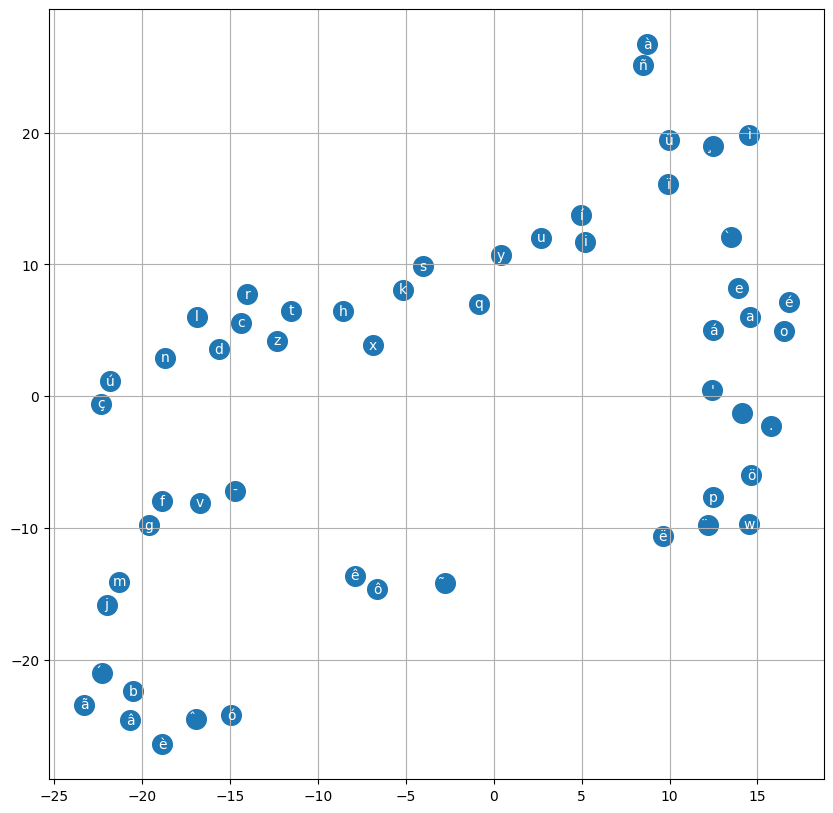

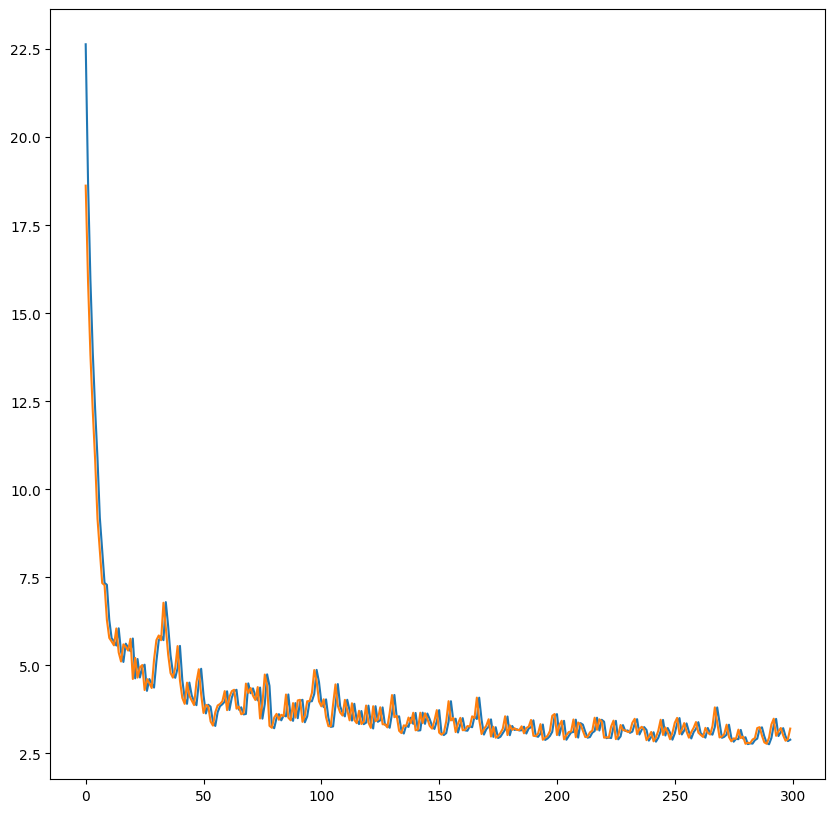

In [79]:
# hiper-parâmetros
context = 3 # mudou para 3
dim = 2
int_neurons = 100
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)

## Experiência 2.1:
- tamanho do contexto: 4
- dimensão dos embeddings: 2
- nº de neurónios intermédios: 100

torch.Size([224893, 4]) torch.Size([224893])
torch.Size([24971, 4]) torch.Size([24971])
torch.Size([32416, 4]) torch.Size([32416])


100%|██████████| 300/300 [02:18<00:00,  2.17it/s]


Dev loss: tensor(2.8036, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.097240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.376122
[t-SNE] KL divergence after 1000 iterations: 0.245236
Test Loss: tensor(2.9556)
Test Accuracy: 0.14721125370187563
              precision    recall  f1-score   support

           0       0.46      0.24      0.31      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.20      0.07      0.10      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.08      0.01      0.02       886
           8       0.12      0.72      0.20      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

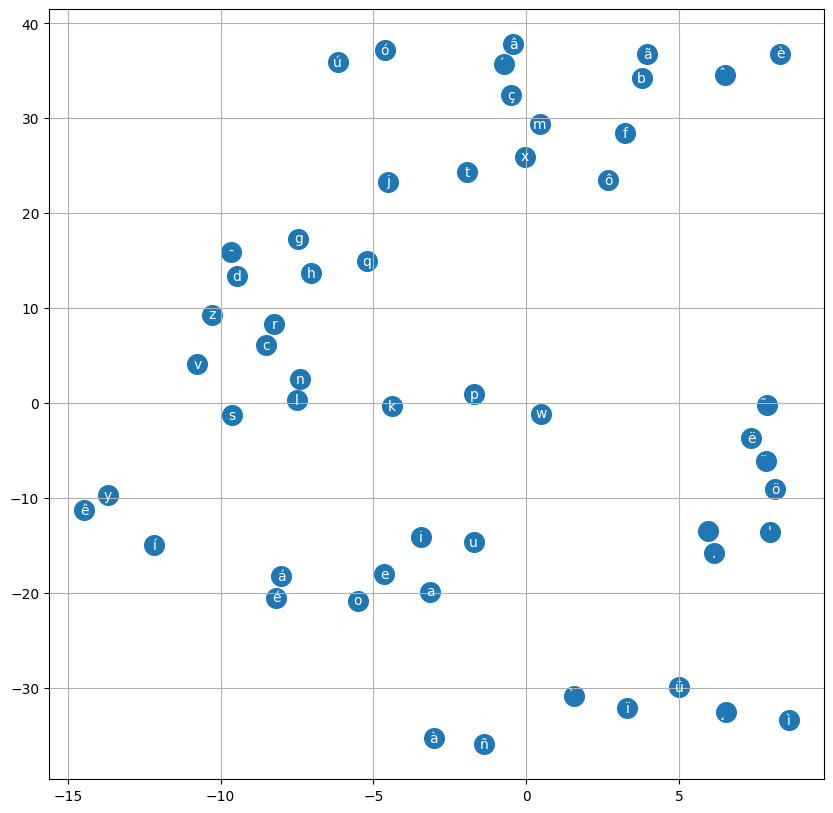

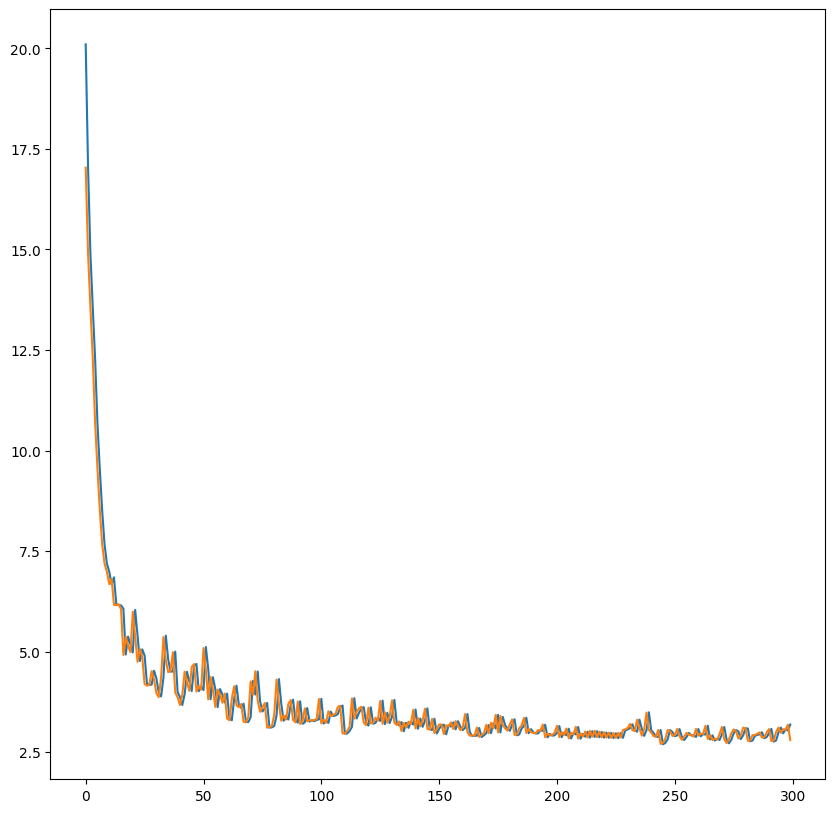

In [80]:
# hiper-parâmetros
context = 4 # mudou para 4
dim = 2
int_neurons = 100
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)

## Experiência 3.0:
- tamanho do contexto: 2
- dimensão dos embeddings: 3
- nº de neurónios intermédios: 100

torch.Size([224893, 2]) torch.Size([224893])
torch.Size([24971, 2]) torch.Size([24971])
torch.Size([32416, 2]) torch.Size([32416])


100%|██████████| 300/300 [02:05<00:00,  2.38it/s]


Dev loss: tensor(2.9251, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.208776
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.287777
[t-SNE] KL divergence after 1000 iterations: 0.204980
Test Loss: tensor(3.1344)
Test Accuracy: 0.15461500493583416
              precision    recall  f1-score   support

           0       0.03      0.00      0.00      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.04      0.02      0.02       886
           8       0.12      0.32      0.17      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

[[ 1 48  0 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


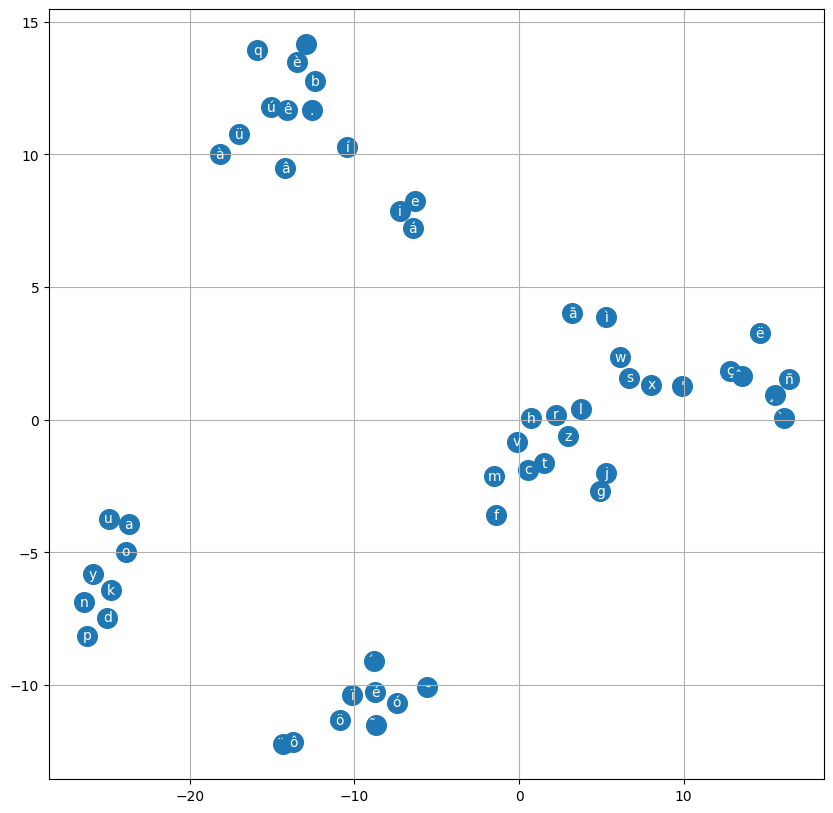

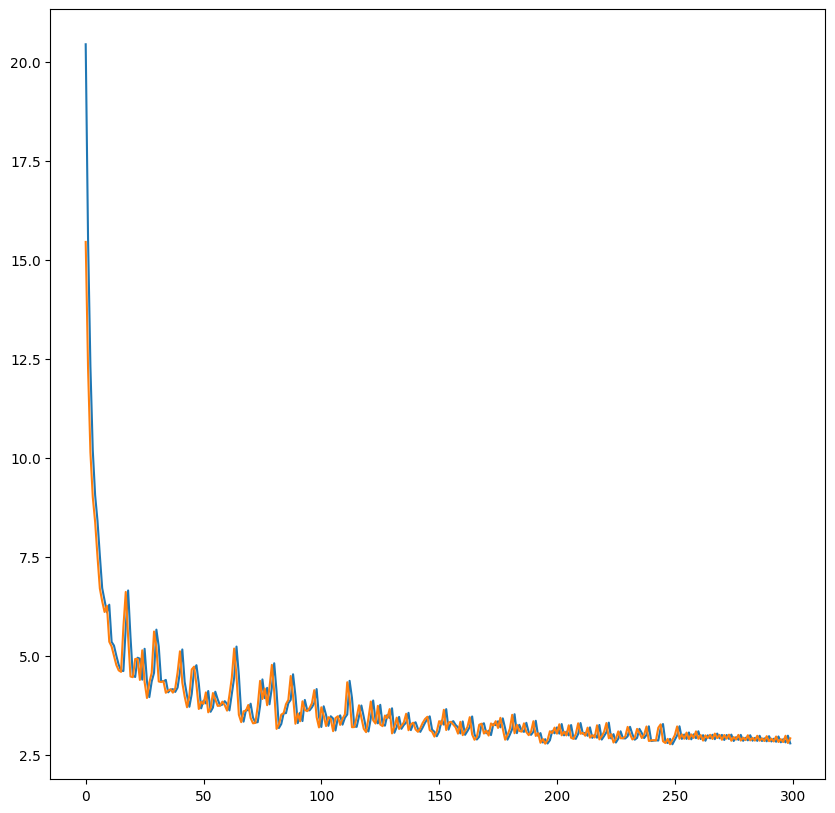

In [81]:
# hiper-parâmetros
context = 2 # mudou para 3
dim = 3 # mudou para 3
int_neurons = 100
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)

## Experiência 3.1:
- tamanho do contexto: 2
- dimensão dos embeddings: 4
- nº de neurónios intermédios: 100

torch.Size([224893, 2]) torch.Size([224893])
torch.Size([24971, 2]) torch.Size([24971])
torch.Size([32416, 2]) torch.Size([32416])


100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


Dev loss: tensor(2.6813, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.352479
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.147167
[t-SNE] KL divergence after 1000 iterations: 0.288850
Test Loss: tensor(2.8402)
Test Accuracy: 0.24629812438302073
              precision    recall  f1-score   support

           0       0.33      0.62      0.43      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.22      0.73      0.34      5053
           5       0.00      0.00      0.00       333
           6       0.06      0.02      0.03       558
           7       0.05      0.00      0.00       886
           8       0.21      0.03      0.06      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

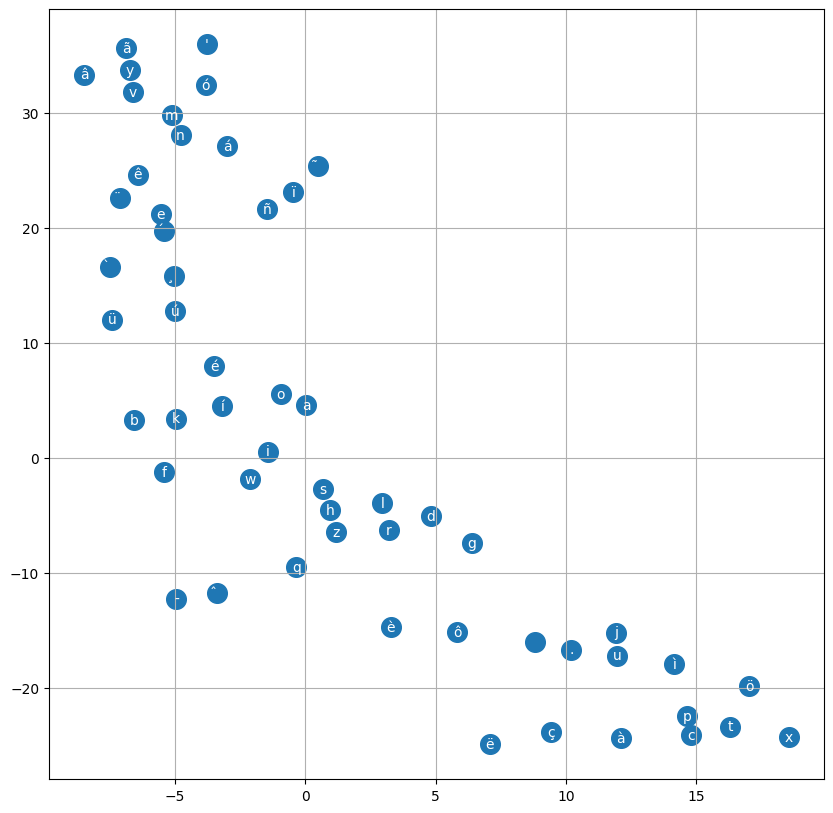

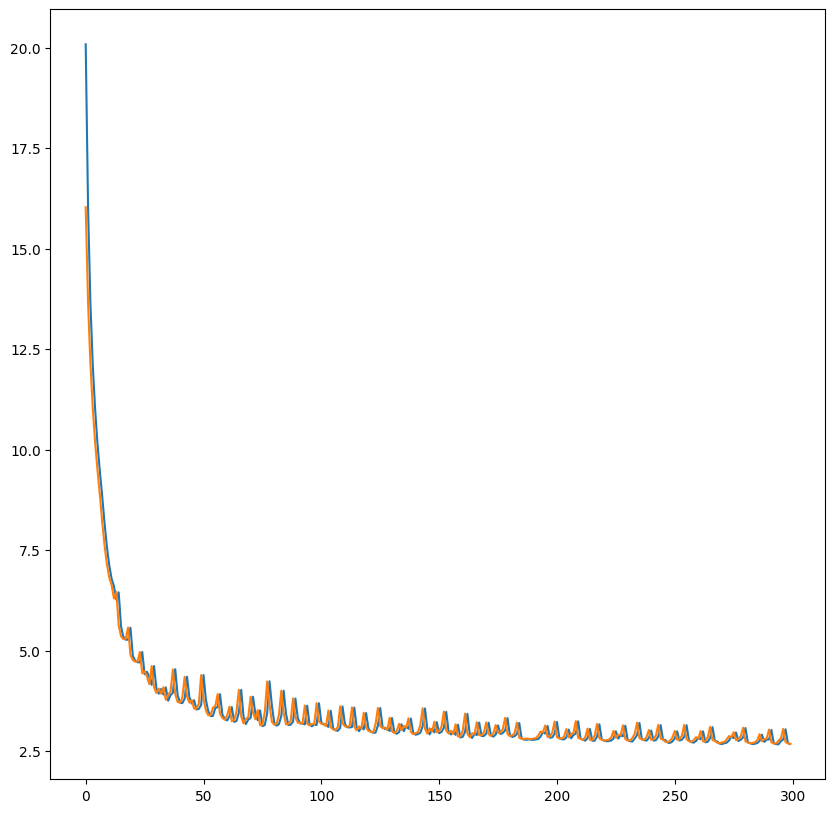

In [82]:
# hiper-parâmetros
context = 2 # voltou para 2
dim = 4 # mudou para 3
int_neurons = 100
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)

## Experiência 4.0:
- tamanho do contexto: 2 
- dimensão dos embeddings: 2
- nº de neurónios intermédios: 50

torch.Size([224893, 2]) torch.Size([224893])
torch.Size([24971, 2]) torch.Size([24971])
torch.Size([32416, 2]) torch.Size([32416])


100%|██████████| 300/300 [01:35<00:00,  3.15it/s]


Dev loss: tensor(2.8262, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.134722
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.926163
[t-SNE] KL divergence after 1000 iterations: 0.272769
Test Loss: tensor(2.8963)
Test Accuracy: 0.17574654491609082
              precision    recall  f1-score   support

           0       0.23      0.80      0.36      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.37      0.10      0.16      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.00      0.00      0.00       886
           8       0.20      0.07      0.10      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

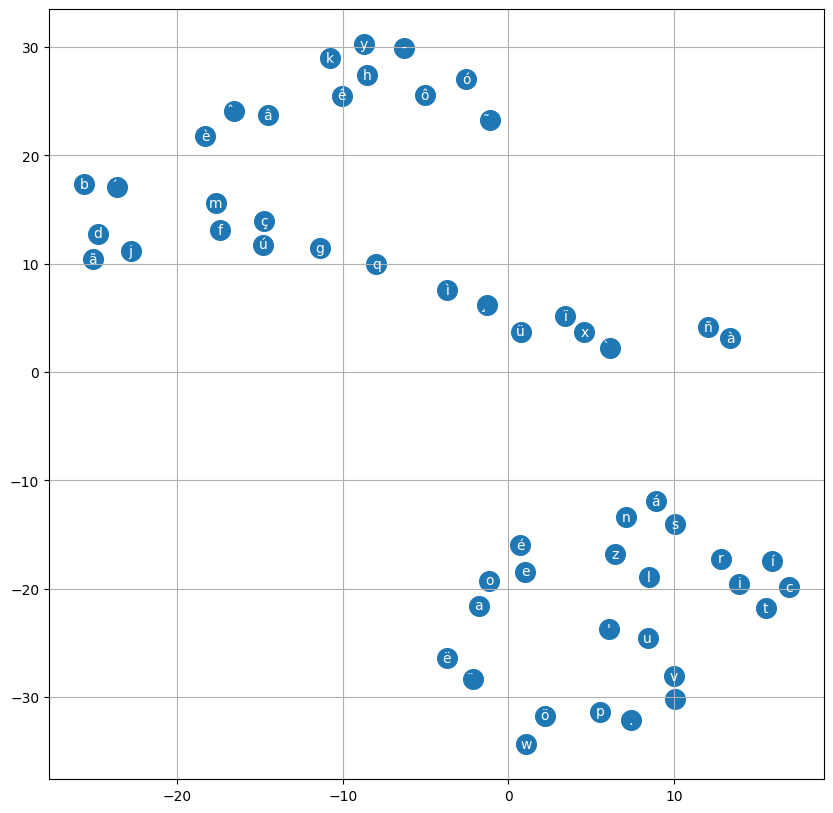

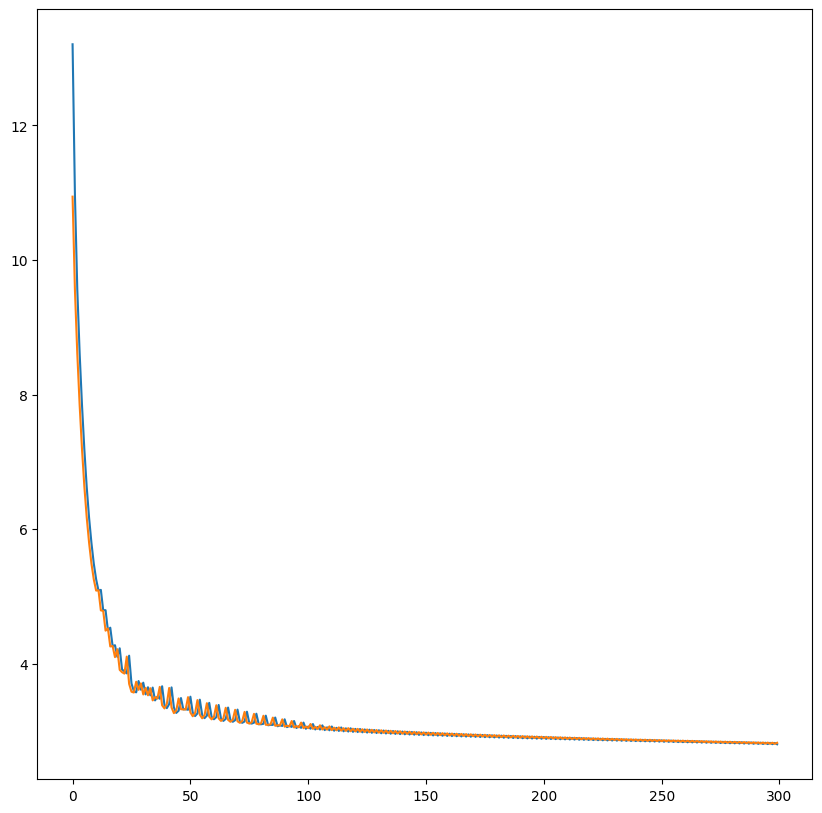

In [83]:
# hiper-parâmetros
context = 2 # voltou para 2
dim = 2 # mudou para 3
int_neurons = 50
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)

## Experiência 5.0:
- tamanho do contexto: 4 
- dimensão dos embeddings: 2
- nº de neurónios intermédios: 50

torch.Size([224893, 2]) torch.Size([224893])
torch.Size([24971, 2]) torch.Size([24971])
torch.Size([32416, 2]) torch.Size([32416])


100%|██████████| 300/300 [01:36<00:00,  3.12it/s]


Dev loss: tensor(2.6332, grad_fn=<NllLossBackward0>)
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.411369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.217808
[t-SNE] KL divergence after 1000 iterations: 0.359186
Test Loss: tensor(2.8020)
Test Accuracy: 0.24194842053307009
              precision    recall  f1-score   support

           0       0.33      0.48      0.40      4573
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        17
           4       0.22      0.80      0.34      5053
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       558
           7       0.12      0.00      0.01       886
           8       0.14      0.06      0.08      2378
           9       0.00      0.00      

/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

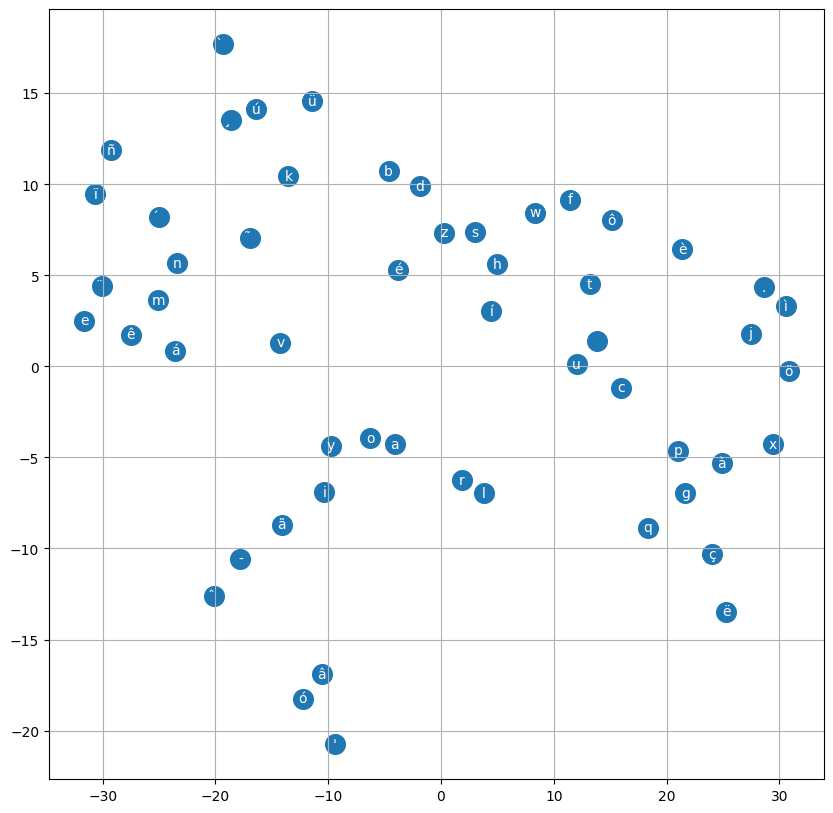

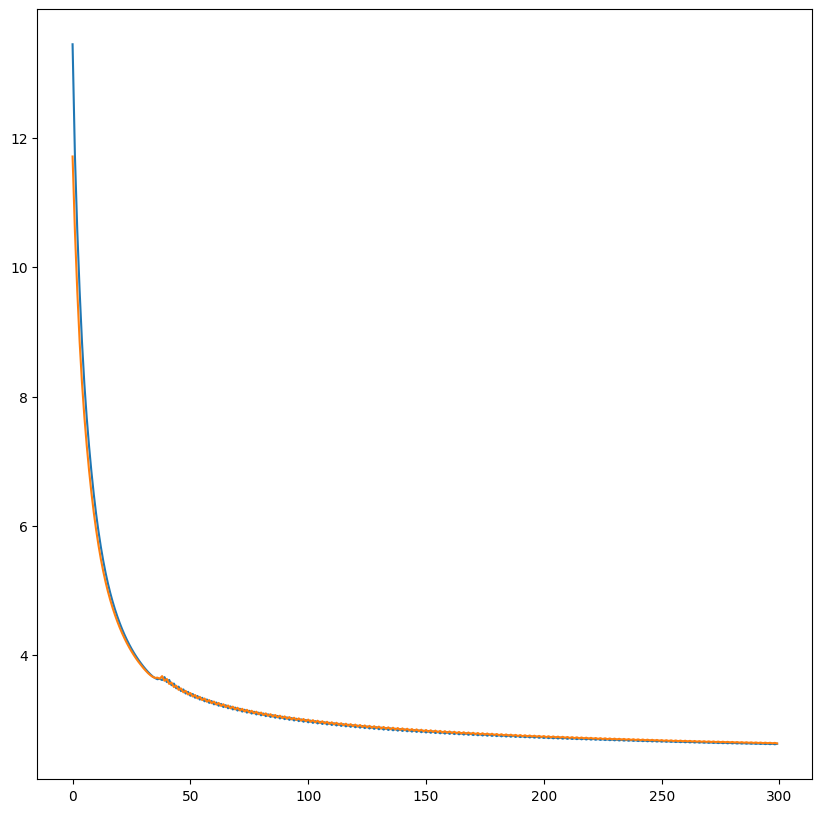

In [85]:
# hiper-parâmetros
context = 2 
dim = 4 
int_neurons = 50 # mudou para metade
lr = 0.5
epochs = 300

experiment(context, dim, int_neurons, lr, epochs)